In [ ]:
# We Could have reset the previous graph of fully connected network.
# Convolutional encoders perform better as they utilize the info that neighbouring pixels are same instead of fully
# connected encoders where there is one row in weight matrix for each pixel (unique weights for every pixels)
# In convolutional networks, filters correspond to weight sharing.

In [1]:
%pylab
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
import IPython.display as ipyd
plt.style.use('ggplot')
from libs.utils import montage
from libs import gif
from libs.datasets import MNIST

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


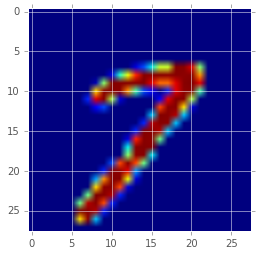

In [2]:
ds = MNIST()
plt.imshow(ds.X[0].reshape(28,28))

(-0.5, 290.5, 290.5, -0.5)

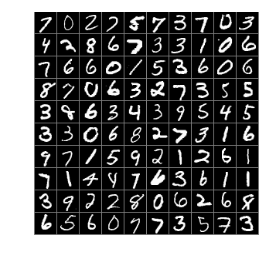

In [3]:
imgs = ds.X[:100].reshape(-1, 28, 28)
plt.imshow(montage(imgs), cmap='gray')
plt.axis('off')

In [4]:
# CONVOLUTIONAL AUTOENCODER
dimensions = [512,256,128,64]
n_features = ds.X.shape[1]   #Because we are considering each pixel of image to be neuron i.e. 784
X = tf.placeholder(tf.float32, [None, n_features])
# Reshaping tensor to 4D tensor for Convolutional network 
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [5]:
n_filters = [8, 16, 32] #conventionally the number of filters increase
filter_sizes = [4, 4, 4]

In [6]:
current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 1

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [7]:
# We'll first reverse the order of our weight matrices
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

([16, 8, 1], [4, 4, 4], [[None, 7, 7, 16], [None, 14, 14, 8], [None, 28, 28, 1]])


In [8]:
# and then loop through our convolution filters and get back our input image
# we'll enumerate the shapes list to get us there
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

In [9]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features]) # Reshaping it for cost function, to make it comparable to input dims

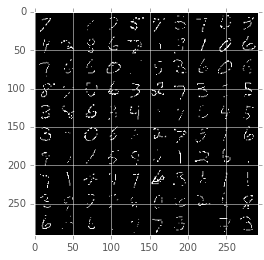

(4, 0.02485525)


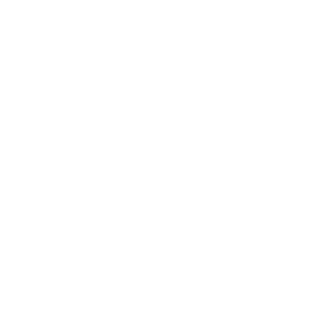

In [10]:
mean_img = np.mean(ds.X, axis=0)
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))
learning_rate = 0.001

# pass learning rate and cost to optimize
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Session to manage vars/train
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
#fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    clear_output()
    plt.imshow(img_i, cmap='gray')
    #fig.canvas.draw()
    plt.show()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')

In [13]:
ipyd.Image(url='conv-ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)